In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from flask import Flask, jsonify

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import create_engine, func, MetaData
from sqlalchemy.ext.declarative import declarative_base

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
metadata = MetaData()
metadata.reflect(bind=engine)
# reflect the tables
for measurement in metadata.tables:
    print(f"Reflected Table: {measurement}")
Base = declarative_base()
class ExampleTable(Base):
    __table__ = metadata.tables['measurement']
Session = sessionmaker(bind=engine)
session = Session()
results = session.query(ExampleTable).all()
for row in results:
    print(row)    

Reflected Table: measurement
Reflected Table: station


In [6]:
# View all of the classes that automap found
Base = automap_base()
Base.prepare(engine, reflect=True)
for class_name in Base.classes:
    print(f"Found class: {class_name}")
ExampleTable = Base.classes.measurement
results = session.query(ExampleTable).all()
for row in results:
    print(row)

Found class: <class 'sqlalchemy.ext.automap.station'>
Found class: <class 'sqlalchemy.ext.automap.measurement'>


In [7]:
# Save references to each table
tables = {}
for measurement in Base.classes.keys():
    tables[measurement] = Base.classes[measurement]
    print(f'Stored reference for table: {measurement}')
Session = sessionmaker(bind=engine)
session = Session()
for measurement in tables:
    ExampleTable = tables[measurement]
    results = session.query(ExampleTable).all()
    for row in results:
        print(row)

Stored reference for table: station
Stored reference for table: measurement


# Exploratory Precipitation Analysis

In [8]:
# Find the most recent date in the data set.
tables = {}
for measurement in Base.classes.keys():
    tables[measurement] = Base.classes[measurement]
Session = sessionmaker(bind=engine)
session = Session()

table_name = 'measurement'
date_column = 'date'

if table_name in tables:
    Table = tables[table_name]
    most_recent_date = session.query(func.max(getattr(Table, date_column))).scalar()
    print(f"The most recent date in {measurement} is: {most_recent_date}")
else:
    print(f"Table {measurement} is not avilable in the stored metadata.")

The most recent date in measurement is: 2017-08-23


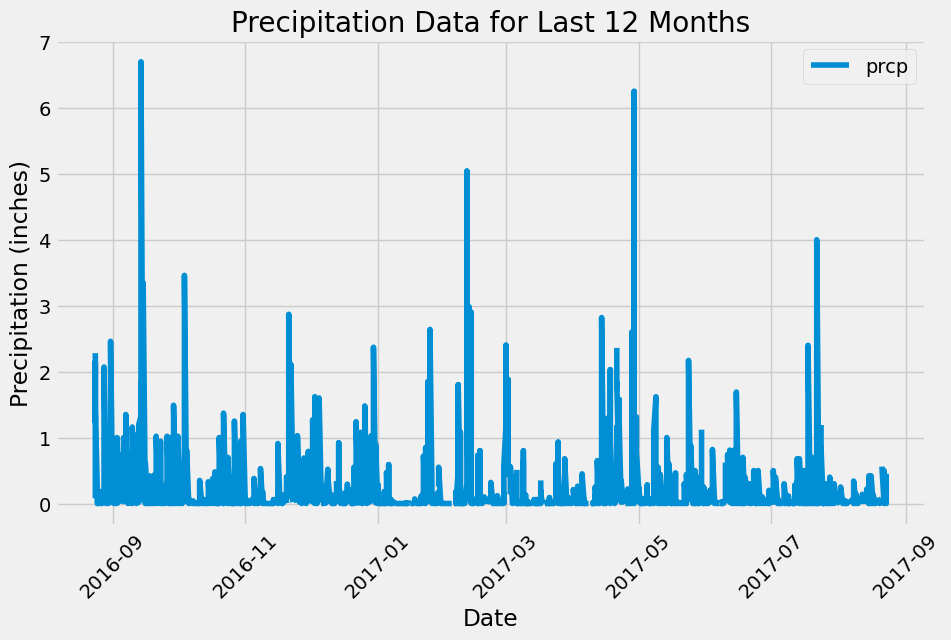

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
Measurement = Base.classes.measurement
most_recent_date = session.query(func.max(Measurement.date)).scalar()
# Calculate the date one year from the last date in data set.
most_recent_date = dt.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago)\
    .filter(Measurement.date <= most_recent_date)\
    .order_by(Measurement.date)\
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(results, columns=['date', 'prcp'])

# Sort the dataframe by date
prcp_df["date"] = pd.to_datetime(prcp_df['date'])
prcp_df.set_index('date', inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(prcp_df.index, prcp_df['prcp'], label='prcp')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Data for Last 12 Months')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [10]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_summary = prcp_df["prcp"].describe()
print(f"Summary staticstics for percipitation data:{prcp_summary}")


Summary staticstics for percipitation data:count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [11]:
# Design a query to calculate the total number of stations in the dataset
Station = Base.classes.station
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [12]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()
print("Most active stations (by number of observations):")
for station, count in active_station:
    print(f"Station ID: {station}, Observations: {count}")


Most active stations (by number of observations):
Station ID: USC00519281, Observations: 2772
Station ID: USC00519397, Observations: 2724
Station ID: USC00513117, Observations: 2709
Station ID: USC00519523, Observations: 2669
Station ID: USC00516128, Observations: 2612
Station ID: USC00514830, Observations: 2202
Station ID: USC00511918, Observations: 1979
Station ID: USC00517948, Observations: 1372
Station ID: USC00518838, Observations: 511


In [13]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station)\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .first()[0]
print(most_active_station)

temperature_stat = session.query(func.min(Measurement.tobs).label("min_temp"),
    func.max(Measurement.tobs).label("max_temp"),
    func.avg(Measurement.tobs).label("avg_temp"))\
    .filter(Measurement.station == most_active_station)\
    .first()

if temperature_stat:
    min_temp, max_temp, avg_temp = temperature_stat
    print(f"Temperature Statistics for Station {most_active_station}:")
    print(f"Lowest Temperature: {min_temp} °F")
    print(f"Highest Temperature: {max_temp} °F")
    print(f"Average Temperature: {avg_temp:.2f} °F")
else:
    print(f"No temperature data found for station {most_active_station}")

USC00519281
Temperature Statistics for Station USC00519281:
Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66 °F


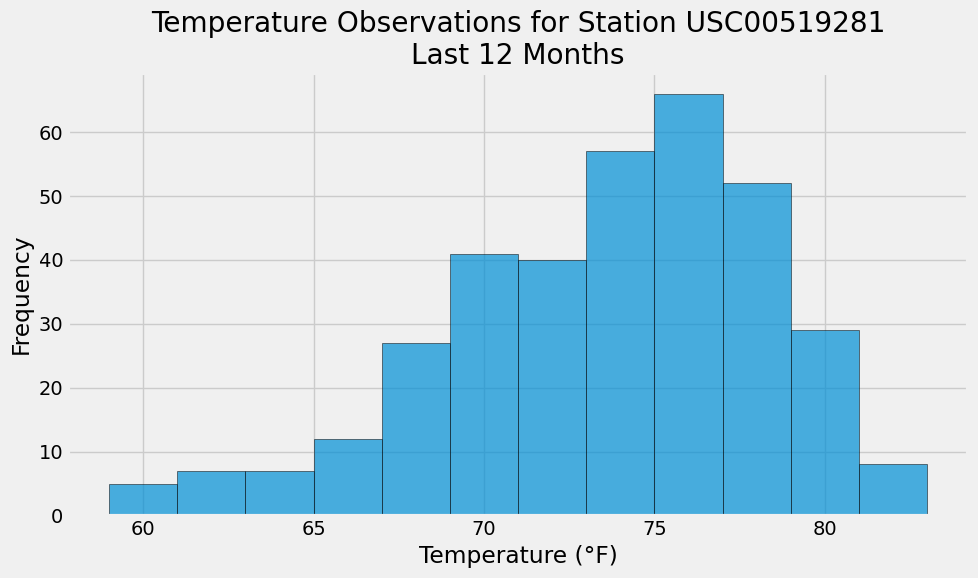

In [14]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_query = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station,
                Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()
temp_df = pd.DataFrame(tobs_query, columns=["date", "tobs"])
plt.figure(figsize=(10, 6))
plt.hist(temp_df['tobs'], bins=12, alpha=0.7, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station}\nLast 12 Months')
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [15]:
app = Flask(__name__)

@app.route('/')
def home():
    return (
        f"Welcome the the Preciptitaion date API<BR/>"
        f"Available routes:<br/>"
        f"/api/stations<br/>"
        f"/api/temperature/<station_id>"
        f'/api/v1.0/tobs<br/>'
    )

@app.route('/api/stations')
def get_stations():
    station_query = session.query(Measurement.station).distinct().all()
    stations = [station[0] for station in station_query]
    return jsonify({"station": stations})

@app.route("/api/temperature/<station>")
def get_temperature_data(station):
    try:
        temp_data_query = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.station == station)
        order_by(Measurement.date).all()

        temperature_data = [{"date":date, "temperature":tobs} for date, tobs in temp_data_query]
        return jsonify({"station":station, "tamperature":tobs})  
    except:
        return jsonify({"error": str(e)})


@app.route('/api/v1.0/precipitation')
def precipitation():
    try:
        most_recent_date_query = session.query(func.max(Measurement.date)).scalar()
        last_12_months_prcp = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= one_year_ago).\
            order_by(Measurement.date).all()
            
        prcp_date = {date.strftime("%Y-%m-%d"): prcp for date, prcp in last_12_months_prcp}

        jsonify(Measurement.date)
    except Exception as e:
        return jsonify({"error": str(e)})

@app.route('/api/v1.0/stations')
def stations():
    try:
        station_query = session.query(Measurement.station).distinct().all()
        stations = [station[0] for station in station_query]
        return jsonify({"station": stations})
    except Exception as e:
        return jsonify({"error": str(e)})

@app.route('/api/v1.0/tobs')
def tobs():
    try:
        most_active_station_query = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).first()
        most_active_station_id = most_active_station_query[0]
        
        tobs_query = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.station == most_active_station_id).\
        filter(Measurement.date >= one_year_ago).\
        order_by(Measurement.date).all()
    
        tobs_data = [{'date': date.strftime('%Y-%m-%d'), 'temperature': tobs} for date, tobs in tobs_query]

        return jsonify({'station': most_active_station_id, 'temperature_observations': tobs_data})

    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    app.run(debug=True)

@app.route('/api/v1.0/<start>')
def temp_start(start):
    try:
        start_date = datetime.strptime(start, '%Y-%m-%d')
        
        temp_stat_query = session.query(
            func.min(Measurement.tobs),
            func.avg(Measurement.tobs),
            func.max(Measurement.tobs)
        ).filter(Measurement.date >= start_date).first()
        
        tmin, tavg, tmax = temp_stats_query
        return jsonify({
            "start_date": start,
            'TMIN': tmin,
            'TAVG': tavg,
            'TMAX': tmax
        })
    except Exception as e:
        return jsonify({"error": str(e)})

@app.route('/api/v1.0/<start>/<end>')
def temp_start_end(start, end):
    try:
        end_date = datetime.strptime(end, '%Y-%m-%d')
        
        temp_stat_query = session.query(
            func.min(Measurement.tobs),
            func.avg(Measurement.tobs),
            func.max(Measurement.tobs)
        ).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).first()
        

        return jsonify({
            'start_date': start,
            'end_date': end,
            'TMIN': tmin,
            'TAVG': tavg,
            'TMAX': tmax
        })
    except Exception as e:
        return jsonify({'error': str(e)})
    

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

In [ ]:
# Close Session
session.close()